## Organ differences by Milo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
import scvelo as scv

import milopy.core as milo
import milopy.plot as milopl

In [3]:
## import project utils
cwd = '../utils/'
sys.path.append(cwd)

import genes
import panfetal_utils

In [4]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/organ_milo_analysis_MYELOID/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir

In [5]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython


In [7]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [8]:
import milopy

def annotate_nhoods(adata, anno_col):
    anno_dummies = pd.get_dummies(adata.obs[anno_col])
    anno_count = adata.obsm["nhoods"].T.dot(scipy.sparse.csr_matrix(anno_dummies.values))
    anno_frac = np.array(anno_count/anno_count.sum(1))

    anno_frac = pd.DataFrame(anno_frac, 
                             columns=anno_dummies.columns,
                             index=adata.uns["nhood_adata"].obs_names
                            )
    adata.uns["nhood_adata"].obsm["frac_annotation"] = anno_frac.values
    adata.uns["nhood_adata"].uns["annotation_labels"] = anno_frac.columns
    adata.uns["nhood_adata"].obs["nhood_annotation"] = anno_frac.idxmax(1)
    adata.uns["nhood_adata"].obs["nhood_annotation_frac"] = anno_frac.max(1)

## Load milo neighbourhoods
Computed in `src/7_differential_abundance`

In [10]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"
split="MYELOID_V2"

In [11]:
outdir = '/nfs/team205/ed6/data/Fetal_immune/milo_outs/{s}/'.format(s=split)
adata = sc.read_h5ad(outdir + "adata4milo.{s}.h5ad".format(s=split))

In [12]:
nhood_adata = sc.read_h5ad(outdir + "milo_nhood_adata.{s}.h5ad".format(s=split))

adata.uns["nhood_adata"] = nhood_adata.copy()

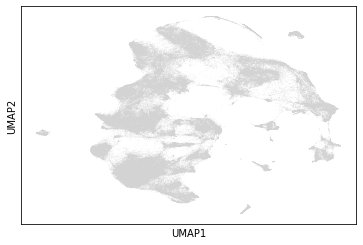

In [13]:
sc.pl.umap(adata)

### Make neighbourhoods
Larger neighbourhoods than for analysis in time (more samples per condition)

In [14]:
## Recompute KNN graph
sc.pp.neighbors(adata, use_rep = "X_scvi", n_neighbors = 100, key_added="scvi")

## Construct neighbourhoods
milo.make_nhoods(adata, neighbors_key="scvi", prop=0.05)

## Count cells in neighbourhoods
milo.count_nhoods(adata, sample_col="Sample.lanes")

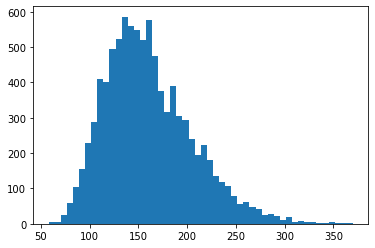

In [15]:
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=50);

In [16]:
def _milo_test_organ_abundance(adata, org, design = '~ method + correction_factor + test_organ'):
    adata.obs['test_organ'] = adata.obs.organ==org
    adata.obs['test_organ'] = adata.obs['test_organ'].astype("str").astype("category")
    milopy.utils.add_covariate_to_nhoods_var(adata, ['test_organ'])
    milo.DA_nhoods(adata, design=design)

milopy.utils.add_covariate_to_nhoods_var(adata, ['method', 'Sort_id', 'donor'])
all_organs = adata.obs.organ.unique().tolist()
design = '~ method + correction_factor + test_organ'

## Calculate logFC and SpatialFDR within each organ
milo_res_dict = {}
for org in all_organs:
    print(org)
    _milo_test_organ_abundance(adata, org)
    milo_res_dict[org] = adata.uns["nhood_adata"].obs.copy()

SK
SP
YS
LI
TH
GU
BM
KI


In [17]:
## Collapse results
logFC_df_ls = [v["logFC"] for k,v in milo_res_dict.items()]
for k,v in milo_res_dict.items():
    milo_res_dict[k]["logFC_" + k] = milo_res_dict[k]["logFC"].copy()
    milo_res_dict[k]["SpatialFDR_" + k] = milo_res_dict[k]["SpatialFDR"].copy()

org_fc = pd.concat([v[["logFC_" + k]] for k,v in milo_res_dict.items()], 1)
org_fdr = pd.concat([v[["SpatialFDR_" + k]] for k,v in milo_res_dict.items()], 1)

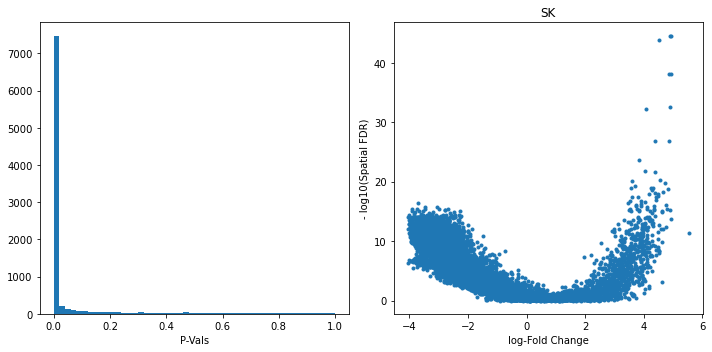

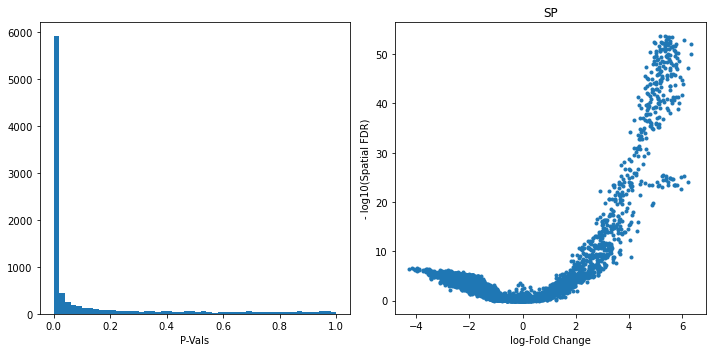

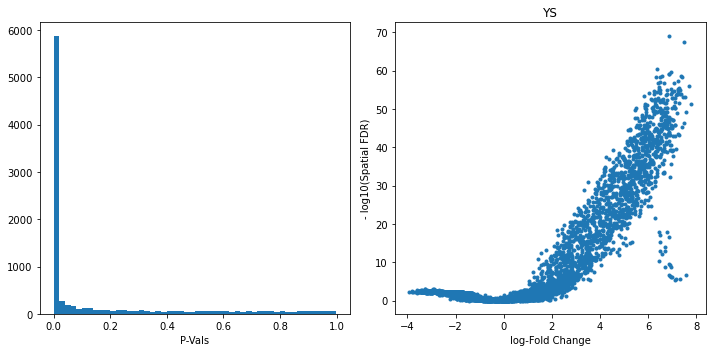

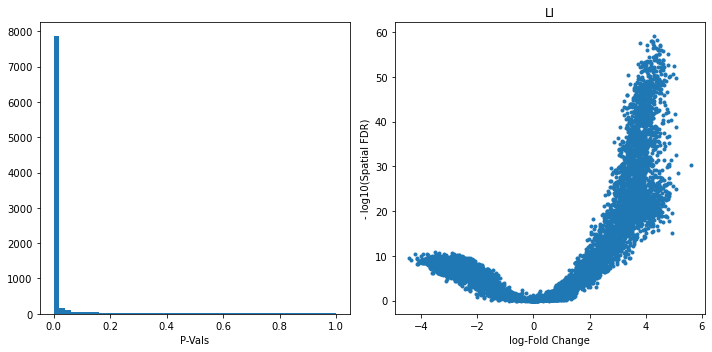

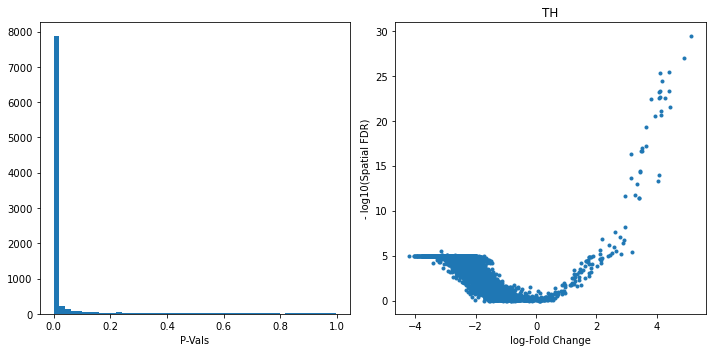

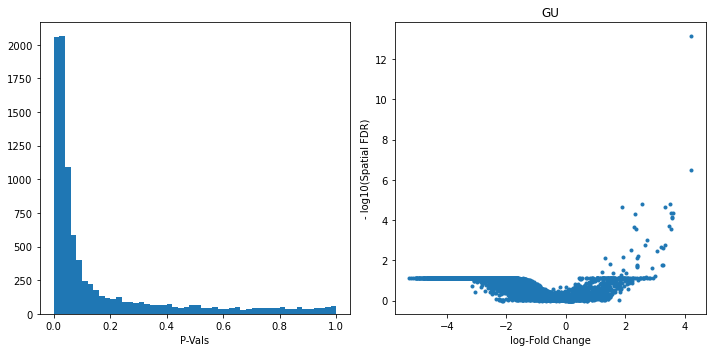

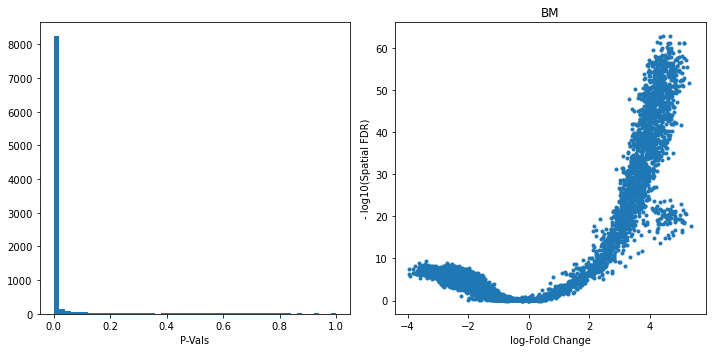

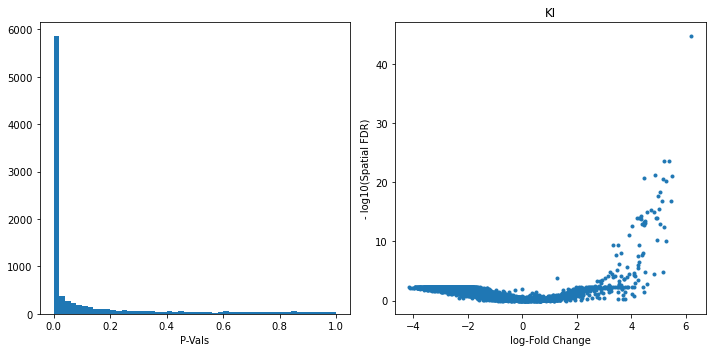

In [19]:
old_figsize = plt.rcParams["figure.figsize"]
for org, milo_res in milo_res_dict.items():
    plt.rcParams["figure.figsize"] = [10,5]
    plt.subplot(1,2,1)
    plt.hist(milo_res.PValue, bins=50);
    plt.xlabel("P-Vals");
    plt.subplot(1,2,2)
    plt.plot(milo_res.logFC, -np.log10(milo_res.SpatialFDR), '.');
    plt.xlabel("log-Fold Change");
    plt.ylabel("- log10(Spatial FDR)");
    plt.title(org);
    plt.tight_layout();
    plt.show()

plt.rcParams["figure.figsize"] = old_figsize

In [20]:
milopy.utils.build_nhood_graph(adata)

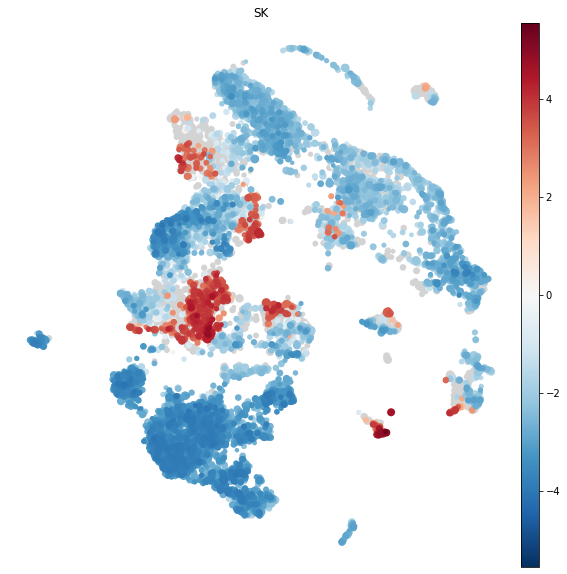

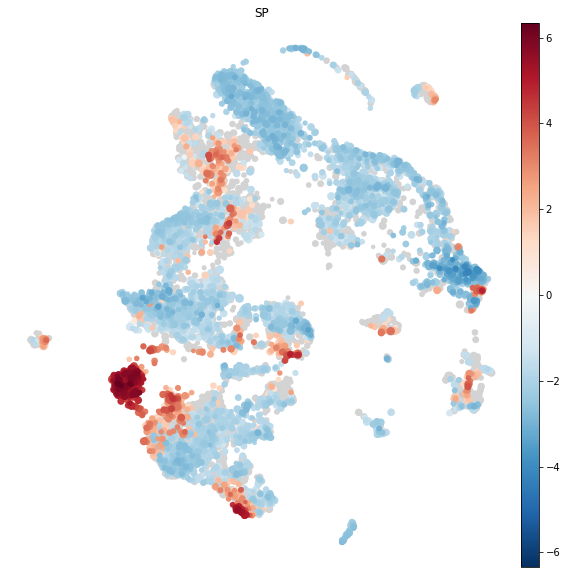

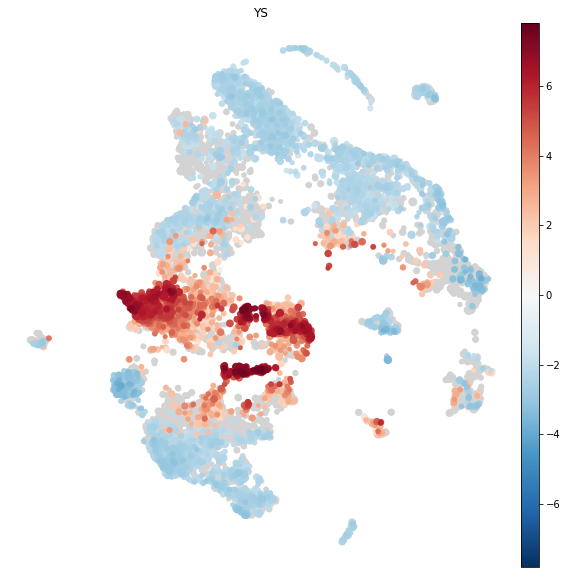

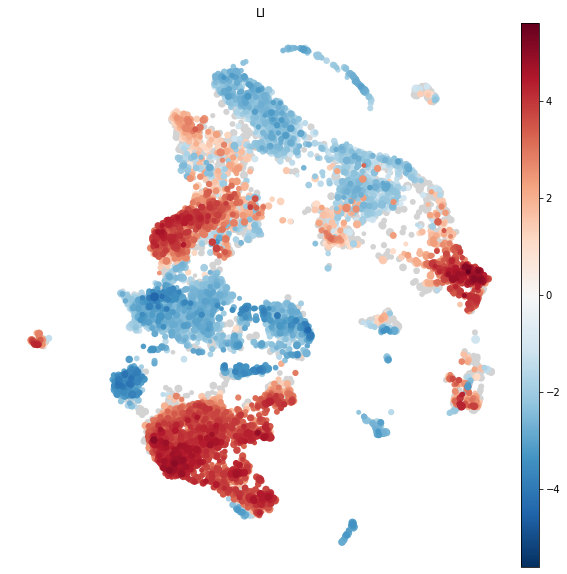

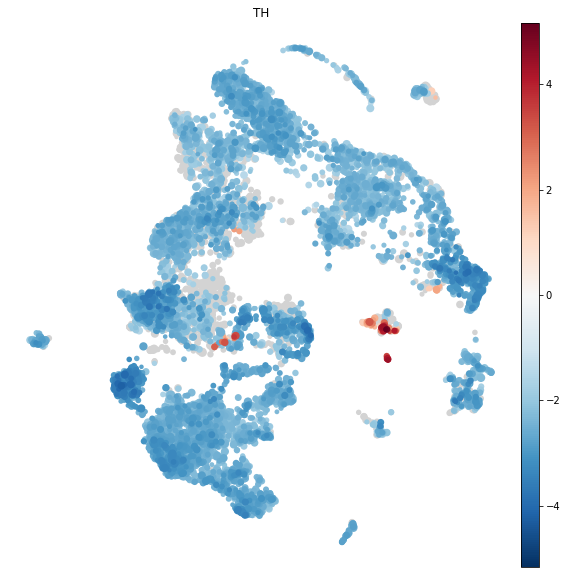

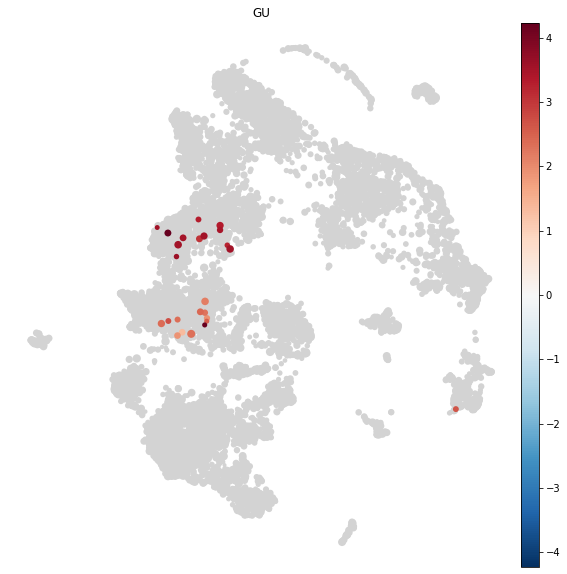

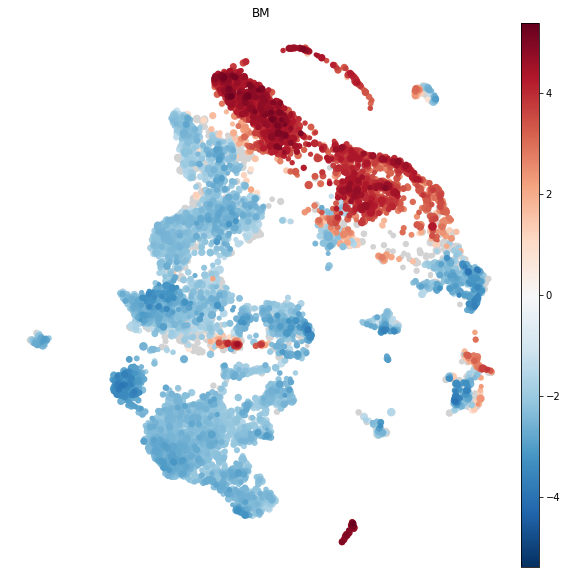

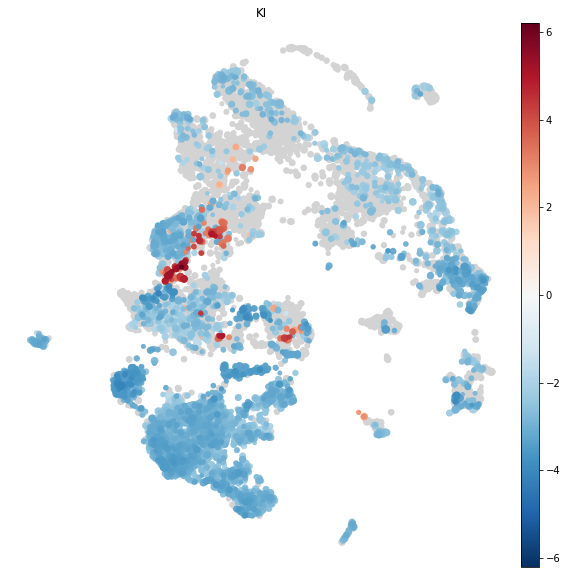

In [21]:
plt.rcParams["figure.figsize"] = [10,10]
milopy.utils.build_nhood_graph(adata)
for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    milopl.plot_nhood_graph(adata, alpha=0.01, min_size=1, title=org)

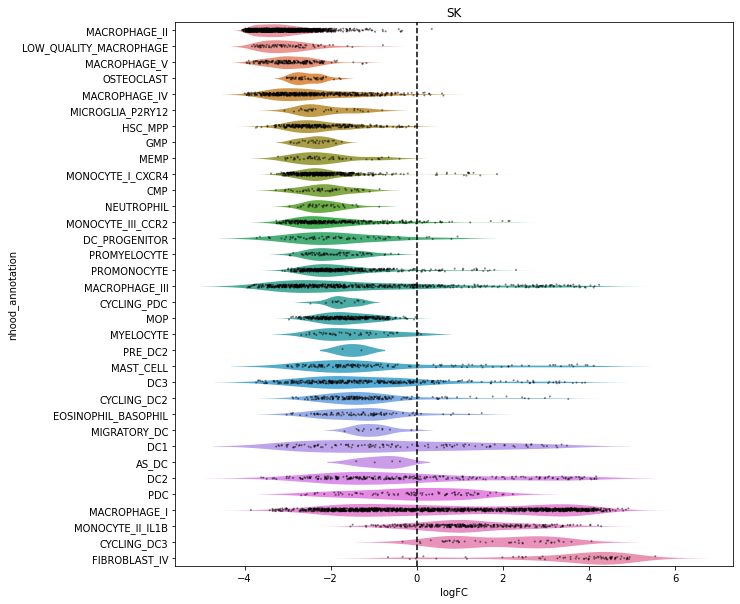

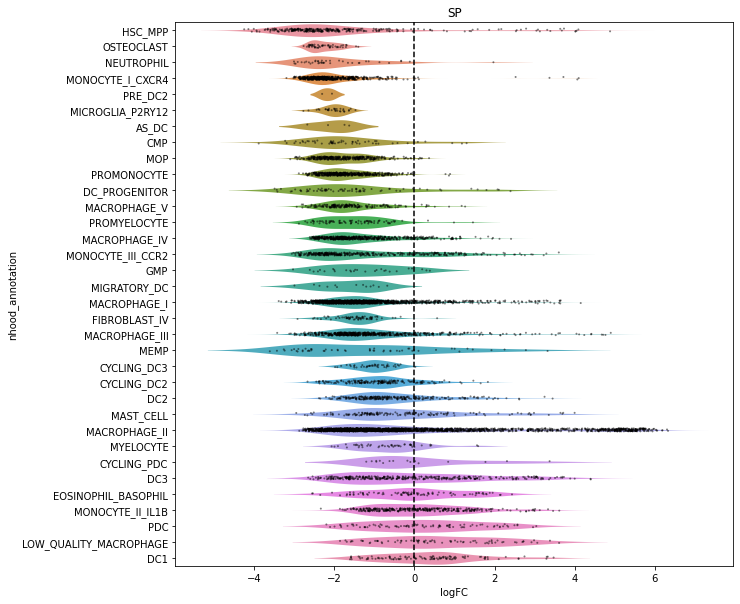

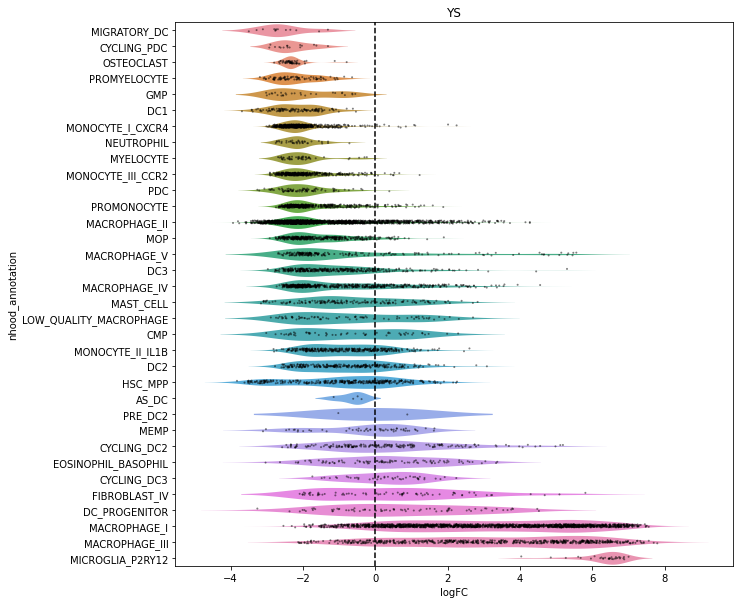

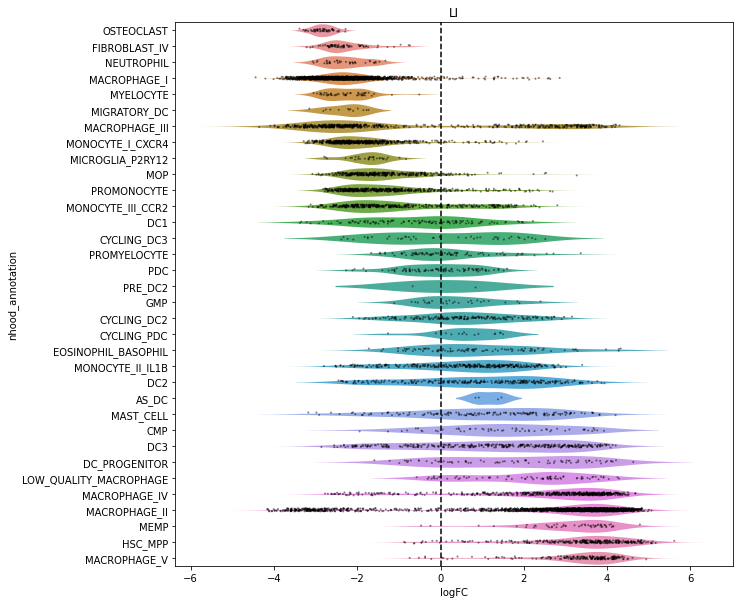

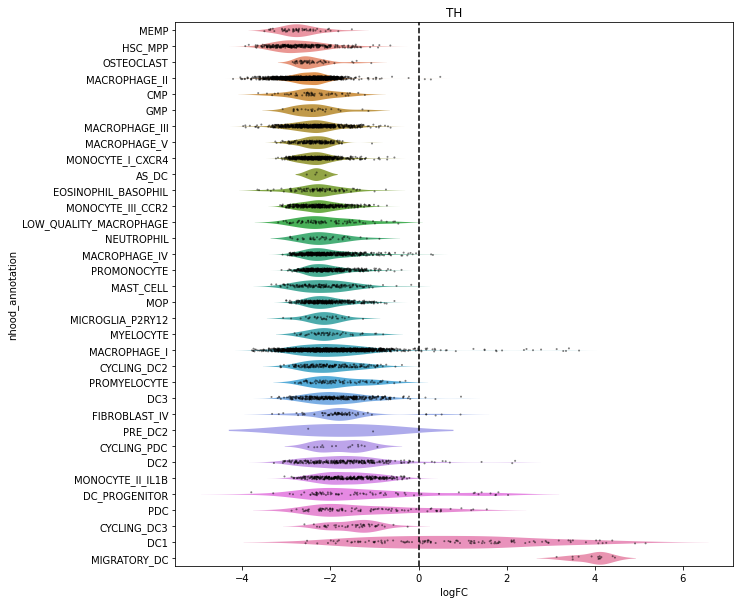

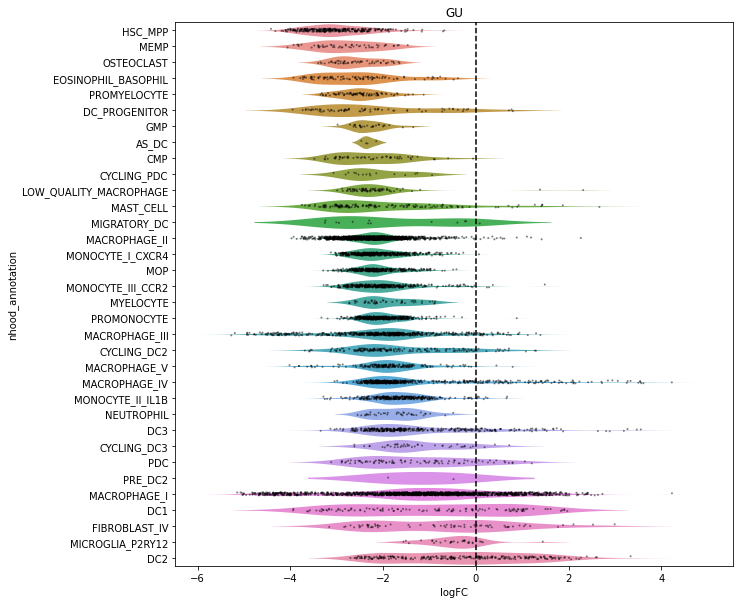

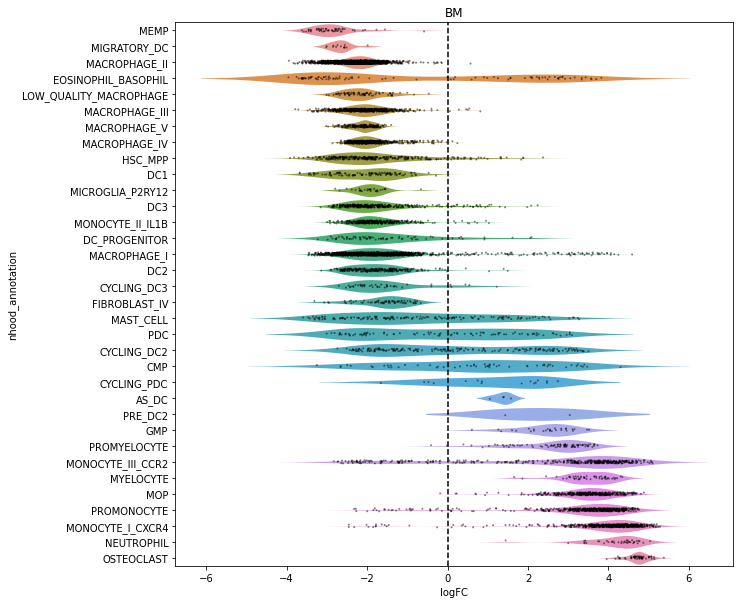

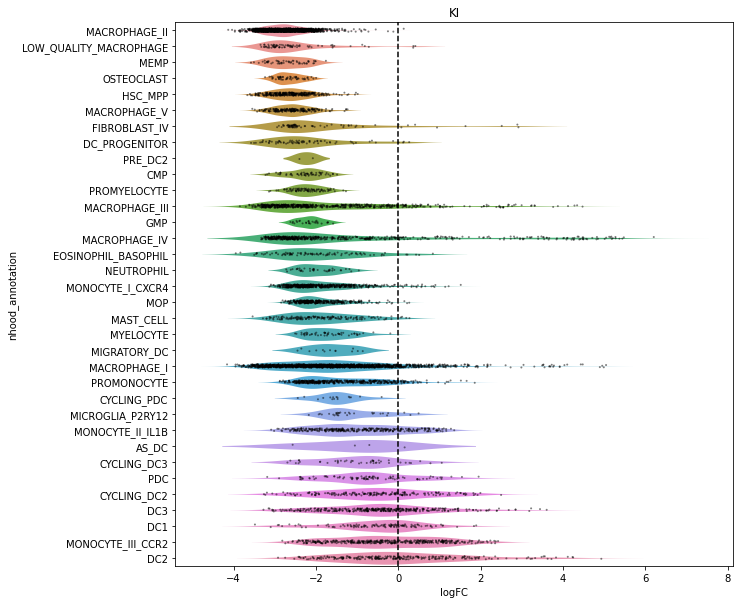

In [22]:

for org, milo_res in milo_res_dict.items():
    adata.uns['nhood_adata'].obs = milo_res.copy()
    milopy.utils.annotate_nhoods(adata, anno_col='anno_lvl_2_final_clean')
    milopl.plot_DA_beeswarm(adata);
    plt.title(org);
    plt.show()

### Visualize with beeswarm plot

In [26]:
anno_groups_dict.keys()

dict_keys(['ERYTHROID CELLS', 'MYELOID', 'OTHER', 'STROMA', 'ILC', 'PROGENITORS', 'NK/T CELLS', 'B CELLS'])

In [23]:
## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)

org_fc_filtered = org_fc.copy()

## Add annotation
annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
org_fc_filtered["nhood_anno"] = adata.uns["nhood_adata"].obs["nhood_annotation"]
org_fc_filtered.loc[adata.uns["nhood_adata"].obs["nhood_annotation_frac"] < 0.5, "nhood_anno"] = "Mixed"

anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}

org_fc_filtered['anno_group'] = [anno_groups_dict_rev[x] if x!="Mixed" else np.nan for x in org_fc_filtered['nhood_anno']]

In [61]:
anno_group_myeloid = {
    "MACs":[x for x in org_fc_filtered.nhood_anno.unique() if "ACROPHAGE" in x],
    'DCs':[x for x in org_fc_filtered.nhood_anno.unique() if "DC" in x],
    "Mono":[x for x in org_fc_filtered.nhood_anno.unique() if "MONO" in x],
    "Progenitors":anno_groups_dict["PROGENITORS"]
    }

anno_group_myeloid['other'] = [x for x in org_fc_filtered.nhood_anno.unique() if x not in sum(anno_group_myeloid.values(),[])]
anno_group_myeloid_rev = {x:g for g,a in anno_group_myeloid.items() for x in a}

org_fc_filtered['anno_group'] = [anno_group_myeloid_rev[x] for x in org_fc_filtered['nhood_anno']]

In [32]:
anno_group_myeloid.keys()

dict_keys(['MACs', 'DCs', 'Mono', 'Progenitors', 'low_confidence', 'other'])

In [34]:
%%R -i org_fc_filtered -i org_fdr -h 1000 -w 800

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 
    
plot_df <- left_join(long_org_fc, long_org_fdr) %>%
    filter(!is.na(logFC)) %>%
    filter(nhood_anno!="nan") %>%
    filter(nhood_anno!="Mixed") %>%
    ## Fix organ naming and order 
    mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ## Fix some names
    mutate(nhood_anno=ifelse(str_detect(nhood_anno, "NK$"), "NK", nhood_anno)) %>%
    ## Reorder by fold-change 
    group_by(organ, nhood_anno, Nhood) %>%
    mutate(mean_logFC = mean(logFC)) %>%
    ungroup() %>%
    group_by(organ, nhood_anno) %>%
    arrange(- mean_logFC) %>%
    ungroup()  %>%
    mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
    group_by(nhood_anno) %>%
    filter(length(unique(Nhood)) > 20) %>%
    ungroup()

head(plot_df)

Joining, by = c("Nhood", "organ")
  Nhood     nhood_anno anno_group organ    logFC   SpatialFDR mean_logFC
1    45 MACROPHAGE_III       MACs    YS 7.797018 5.121459e-52   7.797018
2    77 MACROPHAGE_III       MACs    YS 7.698779 1.270460e-56   7.698779
3  6343 MACROPHAGE_III       MACs    YS 7.561725 1.654278e-07   7.561725
4    42   MACROPHAGE_I       MACs    YS 7.560291 7.140633e-50   7.560291
5  3436   MACROPHAGE_I       MACs    YS 7.509602 6.509057e-54   7.509602
6    67   MACROPHAGE_I       MACs    YS 7.480327 3.351522e-68   7.480327


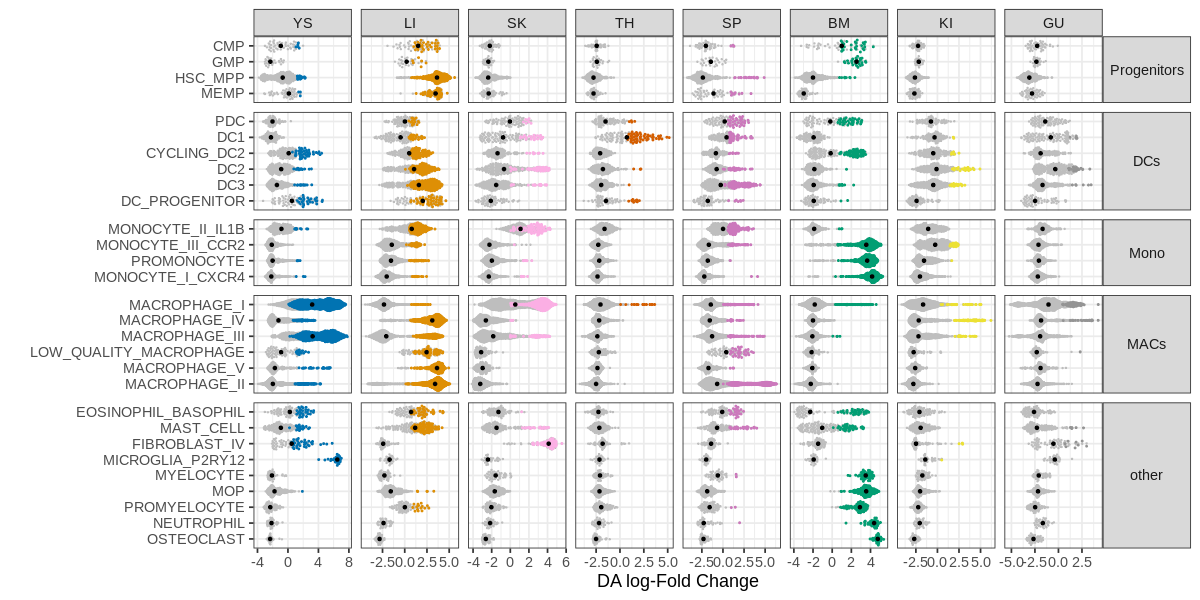

In [35]:
%%R -w 1200 -h 600 -i figdir -o pl_df
library(ggbeeswarm)
organ_colors_df <- read.csv("~/Pan_fetal_immune/metadata/organ_colors.csv")
organ_palette <- setNames(organ_colors_df$color, organ_colors_df$organ)

anno_group_order <- c('Progenitors', 'DCs', 'Mono','MACs',  'low_confidence', 'other')

pl_df <- plot_df %>%
    ## Reorder annotation names by median FC
    group_by(nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    arrange(mean_logFC) %>%
    mutate(nhood_anno=factor(nhood_anno, levels=unique(nhood_anno))) %>%
    ## Calculate median per organ, to plot
    group_by(organ, nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    filter(!is.na(anno_group)) %>%
    filter(anno_group %in% anno_group_order)

alpha=0.1
set.seed(12345)
pl1 <- pl_df %>%
    mutate(organ_color=ifelse((SpatialFDR < alpha) & (logFC > 0), as.character(organ), NA)) %>%
    ggplot(aes(nhood_anno, logFC)) +
    geom_quasirandom(size=0.5, color="grey") +
    geom_quasirandom(data=. %>% filter(SpatialFDR < alpha), size=0.7, aes(color=organ_color)) +
    geom_point(data= . %>% distinct(organ, nhood_anno, anno_group, mean_logFC), aes(x=nhood_anno, y=mean_logFC), color="black")  +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    scale_color_manual(values=organ_palette) +
    scale_fill_manual(values=organ_palette) +
    guides(color="none", fill="none") +
#     geom_hline(yintercept=0, linetype=2) +
    theme_bw(base_size=18) +
    xlab("") + ylab("DA log-Fold Change") +
#     scale_y_continuous(breaks=seq(-3,3, by=1)) +
    theme(strip.text.y=element_text(angle=0))
    
pl1 
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=15, height=15) +
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=15, height=15)

### Visualize with heatmaps

In [163]:
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

org_fc_filtered["hclust_order"] = np.nan
for a in org_fc_filtered.nhood_anno.unique():
    df = org_fc_filtered[org_fc_filtered.nhood_anno==a].drop(['nhood_anno', 'anno_group', 'hclust_order'], 1)
    clustering = ward(df.values)
    ordered_ixs = org_fc_filtered.index[org_fc_filtered.nhood_anno==a][leaves_list(clustering)]
    org_fc_filtered.loc[ordered_ixs, 'hclust_order'] = np.arange(sum(org_fc_filtered.nhood_anno==a))

In [225]:
anno_group_myeloid['MACs']

['MACROPHAGE_I',
 'MACROPHAGE_III',
 'MACROPHAGE_IV',
 'MACROPHAGE_II',
 'MACROPHAGE_V',
 'LOW_QUALITY_MACROPHAGE']

In [ ]:
anno_order = [
    ## Monocytes
    'PROMONOCYTE', 
    'MONOCYTE_I_CXCR4',
    'MONOCYTE_II_IL1B', 
    'MONOCYTE_III_CCR2',
    ## MA
]

In [165]:
%%R -i org_fc_filtered -w 1000 -h 500

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood, hclust_order), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 

In [166]:
%%R
plot_df <- left_join(long_org_fc, long_org_fdr) %>%
    filter(!is.na(logFC)) %>%
    filter(nhood_anno!="nan") %>%
    filter(nhood_anno!="Mixed") %>%
    ## Fix organ naming and order 
    mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) 

head(plot_df)

Joining, by = c("Nhood", "organ")
  Nhood nhood_anno anno_group hclust_order organ      logFC   SpatialFDR
1     1        DC2        DCs            7    SK  3.4590273 1.809622e-08
2     1        DC2        DCs            7    SP -0.3116763 1.782482e-01
3     1        DC2        DCs            7    YS -0.2599339 7.939803e-01
4     1        DC2        DCs            7    LI -2.3428198 1.494179e-09
5     1        DC2        DCs            7    TH -1.4608388 2.492886e-01
6     1        DC2        DCs            7    GU  1.2441350 1.024029e-01


In [220]:
%%R -w 1200 -h 500
plot_organ_FC_hm_group <- function(plot_df, g, logFC_limits = c(0,7), layout_heights=c(1,4)){
    pl_df <- plot_df %>%
        arrange(nhood_anno, hclust_order) %>%
        mutate(Nhood=factor(Nhood, levels=unique(Nhood))) %>%
        mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
        mutate(logFC = pmin(logFC, logFC_limits[2])) %>%
        mutate(logFC = pmax(logFC, logFC_limits[1])) 

    p1 <- pl_df %>%
        filter(anno_group==g) %>%
        ggplot(aes(Nhood,nhood_anno)) +
        geom_tile(fill='black') +
        facet_grid(.~nhood_anno, scales='free', space="free") +
        theme_classic(base_size=18) +
        remove_x_axis() +
        ylab("") +
        theme(axis.line.x=element_blank(), strip.background=element_blank(), strip.text=element_blank()) +
        ggtitle(g)

    p2 <- pl_df %>%
        filter(anno_group==g) %>%
        ggplot(aes(Nhood,organ,  fill=logFC)) +
        geom_tile() +
        facet_grid(.~nhood_anno, scales='free', space="free") +
        scale_fill_viridis_c(limits=logFC_limits, name='Organ enrichment\n(logFC)') +
        theme_classic(base_size=18) +
        xlab("Neighbourhood") +
        theme(strip.background=element_blank(), strip.text=element_blank(), 
              axis.line.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank()) 

    (p1 / p2 ) + plot_layout(heights=layout_heights, guides='collect')
    } 
for (g in unique(plot_df$anno_group)){
    plot_organ_FC_hm_group(plot_df, g) + 
    ggsave(paste0(figdir, "enrichment_hm_", g, '.pdf'), width=15, height=7) +
    ggsave(paste0(figdir, "enrichment_hm_", g, '.png'), width=15, height=7)
}

---

In [90]:
li_bm_df = org_fc[['logFC_LI', "logFC_BM"]]
li_bm_df['nhood_annotation'] = adata.uns['nhood_adata'].obs['nhood_annotation']

In [101]:
li_bm_df.nhood_annotation = li_bm_df.nhood_annotation.astype('str')

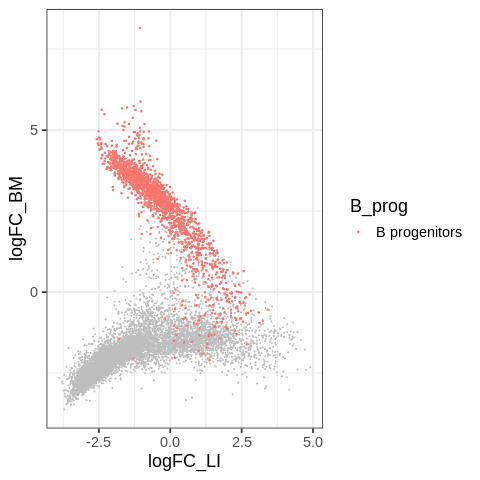

In [116]:
%%R -i li_bm_df
li_bm_df %>%
    rownames_to_column('Nhood') %>%
    mutate(B_prog = ifelse(nhood_annotation %in% c("PRO_B", "LATE_PRO_B", "PRE_PRO_B", 'LARGE_PRE_B', "SMALL_PRE_B"), 'B progenitors', 'NA')) %>%
    ggplot(aes(logFC_LI, logFC_BM, color=B_prog)) +
    geom_point(size=0.3, color='grey') +
    geom_point(data=. %>% filter(B_prog=="B progenitors"), size=0.5) +
    theme_bw(base_size=18)

In [82]:
li_bm_df = org_fc[['logFC_TH', "logFC_SP"]]
li_bm_df['nhood_annotation'] = adata.uns['nhood_adata'].obs['nhood_annotation']

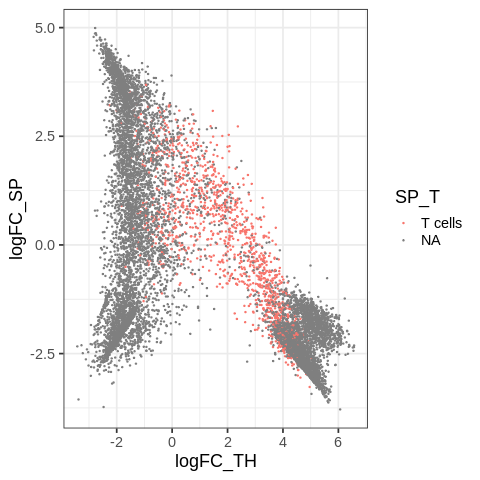

In [86]:
%%R -i li_bm_df
li_bm_df %>%
    mutate(SP_T = ifelse(nhood_annotation %in% c("CD4+T", "CD8+T", "TREG"), 
                           'T cells', NA)) %>%
    ggplot(aes(logFC_TH, logFC_SP, color=SP_T)) +
    geom_point(size=0.5) +
    theme_bw(base_size=18)